##### Copyright 2021 Qiyang Hu

In [ ]:
#@title Licensed under MIT License (the "License");
# You may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/learning_sklearn/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

The data and code snippets of scikit-learn and keras were adopted from the [benchmark](https://github.com/koaning/benchmarks/blob/main/neural-networks/experiment.py) work.  

## Library Imports

In [2]:
import time
import typer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import sklearn
print("Scikit-learn version: ", sklearn.__version__)

Scikit-learn version:  1.2.2


In [ ]:
import keras
print("Keras version: ", keras.__version__)
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)

Keras version:  2.8.0
Tensorflow version:  2.8.2


In [ ]:
import datetime
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import OrderedDict
import torch.optim as optim
print("PyTorch version: ", torch.__version__)

PyTorch version:  1.11.0+cu113


## A small text classification data

In [ ]:
!wget https://raw.githubusercontent.com/koaning/tokenwiser/main/data/oos-intent.jsonl

--2022-06-23 18:21:17--  https://raw.githubusercontent.com/koaning/tokenwiser/main/data/oos-intent.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1831657 (1.7M) [text/plain]
Saving to: ‘oos-intent.jsonl’

oos-intent.jsonl    100%[===================>]   1.75M  --.-KB/s    in 0.05s   

2022-06-23 18:21:17 (37.1 MB/s) - ‘oos-intent.jsonl’ saved [1831657/1831657]



In [ ]:
url = "oos-intent.jsonl"
df = pd.read_json(url, lines=True)

In [ ]:
print(df)

                                         text      label
0            how would you say fly in italian  translate
1           what's the spanish word for pasta  translate
2         how would they say butter in zambia  translate
3              how do you say fast in spanish  translate
4         what's the word for trees in norway  translate
...                                       ...        ...
23695      what does it mean to have equality        oos
23696  what site publishes the most fake news        oos
23697          can you tell me some fake news        oos
23698                 is cnn really fake news        oos
23699                  why is there fake news        oos

[23700 rows x 2 columns]


In [ ]:
X, y = CountVectorizer().fit_transform(df['text']), df['label']

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print("X_train type = ", type(X_train),"\t shape = ", X_train.shape)
print("X_test  type = ", type(X_test),"\t shape = ", X_test.shape)
print("y_train type = ", type(y_train),"\t shape = ", y_train.shape)
print("y_test  type = ", type(y_test),"\t shape = ", y_test.shape)

X_train type =  <class 'scipy.sparse.csr.csr_matrix'> 	 shape =  (15879, 7233)
X_test  type =  <class 'scipy.sparse.csr.csr_matrix'> 	 shape =  (7821, 7233)
y_train type =  <class 'pandas.core.series.Series'> 	 shape =  (15879,)
y_test  type =  <class 'pandas.core.series.Series'> 	 shape =  (7821,)


In [ ]:
label_enc = CountVectorizer().fit(y_train)
y_lab_train = label_enc.transform(y_train)
y_lab_test = label_enc.transform(y_test)

In [ ]:
print("y_lab_train type = ", type(y_lab_train), "\t shape = ", y_lab_train.shape)
print("y_lab_test  type = ", type(y_lab_test), "\t shape = ", y_lab_test.shape)

y_lab_train type =  <class 'scipy.sparse.csr.csr_matrix'> 	 shape =  (15879, 151)
y_lab_test  type =  <class 'scipy.sparse.csr.csr_matrix'> 	 shape =  (7821, 151)


In [ ]:
X_dense = X_train.todense()
y_dense = y_lab_train.todense()
print("X_dense type is", type(X_dense), "\t shape = ", X_dense.shape)
print("y_dense type is", type(y_dense), "\t shape = ", y_dense.shape)

X_dense type is <class 'numpy.matrix'> 	 shape =  (15879, 7233)
y_dense type is <class 'numpy.matrix'> 	 shape =  (15879, 151)


## Scikit-Learn Multi-layer Perceptron Implementation

In [ ]:
def run_sklearn(X_train, X_test, y_train, y_test):
    from sklearn.neural_network import MLPClassifier

    t0 = time.time()
    model = MLPClassifier().fit(X_train, y_train)
    t1 = time.time()
    pred = model.predict(X_test)
    t2 = time.time()
    acc = np.mean(pred == y_test)
    return {"train_time": t1 - t0, "pred_time": t2 - t1, "acc": float(acc), "variant": "sklearn"}

In [ ]:
def run_skearly(X_train, X_test, y_train, y_test):
    from sklearn.neural_network import MLPClassifier

    t0 = time.time()
    model = MLPClassifier(early_stopping=True).fit(X_train, y_train)
    t1 = time.time()
    pred = model.predict(X_test)
    t2 = time.time()
    acc = np.mean(pred == y_test)
    return {"train_time": t1 - t0, "pred_time": t2 - t1, "acc": float(acc), "variant": "skearly"}

## Keras Implementation

In [ ]:
def run_keras(X_train, X_test, y_train, y_test):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.optimizer_v2.adam import Adam

    label_enc = CountVectorizer().fit(y_train)
    y_lab_train = label_enc.transform(y_train)
    y_lab_test = label_enc.transform(y_test)

    clf = Sequential()
    clf.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    clf.add(Dense(y_lab_train.shape[1], activation='sigmoid',))
    clf.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])

    t0 = time.time()
    X_dense, y_dense = X_train.todense(), y_lab_train.todense()
    clf.fit(x=X_dense, y=y_dense, epochs=10)
    t1 = time.time()
    pred = np.argmax(clf.predict(X_test.todense()), axis=1)
    t2 = time.time()
    true_vals = np.asarray(np.argmax(y_lab_test.todense(), axis=1)).flatten()
    acc = np.mean(pred == true_vals)
    return {"train_time": t1 - t0, "pred_time": t2 - t1, "acc": float(acc), "variant": "keras"}

## PyTorch Implementation

In [ ]:
def run_torch(X_train, X_test, y_train, y_test):
    label_enc = CountVectorizer().fit(y_train)
    y_lab_train = label_enc.transform(y_train)
    y_lab_test = label_enc.transform(y_test)
    X_dense = X_train.todense()
    y_dense = y_lab_train.todense()

    dl_train = DataLoader(TensorDataset(torch.tensor(X_dense).float(), torch.tensor(y_dense).float()), shuffle=True, batch_size=256)

    seq_model = nn.Sequential(OrderedDict([
        ('hidden_linear', nn.Linear(X_train.shape[1], 100)),
        ('hidden_activation', nn.ReLU()),
        ('output_linear', nn.Linear(100, y_lab_train.shape[1]))
    ]))

    n_epochs = 10
    optimizer = optim.Adam(seq_model.parameters(), lr=0.02)
    loss_fn = nn.CrossEntropyLoss()
    metric_name = "accuracy"

    def metric_func(y_pred, y_test):
        pred = np.argmax(y_pred.data, axis=1).numpy()
        true_vals = np.asarray(np.argmax(y_test, axis=1)).flatten()
        return np.mean(pred == true_vals)

    t0 = time.time()

    for epoch in range(1, n_epochs+1):
        seq_model.train()
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1
        t00 = time.time()
        for step, (features,labels) in enumerate(dl_train,1):
            optimizer.zero_grad()
            preds = seq_model(features)
            loss = loss_fn(preds, labels)
            metric = metric_func(preds, labels)
            loss.backward()
            optimizer.step()
            metric_sum += metric.item()
            loss_sum += loss.item()
        t01 = time.time()
        info = (epoch, t01-t00, loss_sum/step, metric_sum/step)
        print(("Epoch = %d/" +  str(n_epochs) + ", time: %.3f s, loss = %.3f,"+ metric_name + " = %.3f") %info)
    t1 = time.time()
    y_pred = seq_model(torch.tensor(X_test.todense()).float()).data
    pred = np.argmax(y_pred, axis=1)
    t2 = time.time()
    true_vals = np.asarray(np.argmax(y_lab_test.todense(), axis=1)).flatten()
    acc = np.mean(pred.numpy() == true_vals)
    return {"train_time": t1 - t0, "pred_time": t2 - t1, "acc": float(acc), "variant": "pytorch"}

## Performance Tests

In [ ]:
print(run_sklearn(X_train, X_test, y_train, y_test))

{'train_time': 268.02961015701294, 'pred_time': 0.08180093765258789, 'acc': 0.9138217619230278, 'variant': 'sklearn'}


In [ ]:
print(run_skearly(X_train, X_test, y_train, y_test))

{'train_time': 86.54920196533203, 'pred_time': 0.09106016159057617, 'acc': 0.9197033627413375, 'variant': 'skearly'}


In [ ]:
print(run_keras(X_train, X_test, y_train, y_test))

Epoch 1/10
497/497 [==============================] - 13s 21ms/step - loss: 3.2659 - accuracy: 0.3803
Epoch 2/10
497/497 [==============================] - 10s 21ms/step - loss: 0.7508 - accuracy: 0.8849
Epoch 3/10
497/497 [==============================] - 11s 23ms/step - loss: 0.3335 - accuracy: 0.9432
Epoch 4/10
497/497 [==============================] - 9s 19ms/step - loss: 0.1959 - accuracy: 0.9676
Epoch 5/10
497/497 [==============================] - 9s 19ms/step - loss: 0.1275 - accuracy: 0.9818
Epoch 6/10
497/497 [==============================] - 8s 16ms/step - loss: 0.0879 - accuracy: 0.9884
Epoch 7/10
497/497 [==============================] - 6s 12ms/step - loss: 0.0631 - accuracy: 0.9922
Epoch 8/10
497/497 [==============================] - 6s 12ms/step - loss: 0.0465 - accuracy: 0.9948
Epoch 9/10
497/497 [==============================] - 6s 12ms/step - loss: 0.0354 - accuracy: 0.9962
Epoch 10/10
497/497 [==============================] - 5s 11ms/step - loss: 0.0272 - acc

In [ ]:
print(run_torch(X_train, X_test, y_train, y_test))

Epoch = 1/10, time: 2.547 s, loss = 1.477,accuracy = 0.690
Epoch = 2/10, time: 2.337 s, loss = 0.116,accuracy = 0.970
Epoch = 3/10, time: 2.398 s, loss = 0.045,accuracy = 0.988
Epoch = 4/10, time: 2.264 s, loss = 0.021,accuracy = 0.995
Epoch = 5/10, time: 2.212 s, loss = 0.015,accuracy = 0.997
Epoch = 6/10, time: 2.260 s, loss = 0.011,accuracy = 0.998
Epoch = 7/10, time: 2.482 s, loss = 0.010,accuracy = 0.998
Epoch = 8/10, time: 3.238 s, loss = 0.012,accuracy = 0.997
Epoch = 9/10, time: 2.372 s, loss = 0.009,accuracy = 0.998
Epoch = 10/10, time: 2.089 s, loss = 0.006,accuracy = 0.999
{'train_time': 24.208744049072266, 'pred_time': 0.595595121383667, 'acc': 0.9144610663598005, 'variant': 'pytorch'}


In [ ]:
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=9c9b322dc64fc3f06c354ad6b9804d7e7321aac302c5cf3e047453393dad231b
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [ ]:
%load_ext memory_profiler

Peak memory refers to the peak memory usage of your system (including memory usage of other processes) during the program runtime.

Increment is the increment in memory usage relative to the memory usage just before the program is run (i.e. increment = peak memory - starting memory).

In [ ]:
%memit run_sklearn(X_train, X_test, y_train, y_test)

peak memory: 5174.36 MiB, increment: 0.02 MiB


In [ ]:
%memit run_skearly(X_train, X_test, y_train, y_test)

peak memory: 4957.23 MiB, increment: 3.88 MiB


In [ ]:
%memit run_keras(X_train, X_test, y_train, y_test)

Epoch 1/10
497/497 [==============================] - 8s 16ms/step - loss: 3.2699 - accuracy: 0.3876
Epoch 2/10
497/497 [==============================] - 7s 14ms/step - loss: 0.7381 - accuracy: 0.8892
Epoch 3/10
497/497 [==============================] - 7s 14ms/step - loss: 0.3270 - accuracy: 0.9444
Epoch 4/10
497/497 [==============================] - 7s 13ms/step - loss: 0.1920 - accuracy: 0.9691
Epoch 5/10
497/497 [==============================] - 7s 15ms/step - loss: 0.1248 - accuracy: 0.9818
Epoch 6/10
497/497 [==============================] - 7s 15ms/step - loss: 0.0863 - accuracy: 0.9885
Epoch 7/10
497/497 [==============================] - 7s 14ms/step - loss: 0.0623 - accuracy: 0.9923
Epoch 8/10
497/497 [==============================] - 7s 14ms/step - loss: 0.0460 - accuracy: 0.9952
Epoch 9/10
497/497 [==============================] - 6s 13ms/step - loss: 0.0346 - accuracy: 0.9963
Epoch 10/10
497/497 [==============================] - 7s 14ms/step - loss: 0.0271 - accura

In [ ]:
%memit run_torch(X_train, X_test, y_train, y_test)

Epoch = 1/10, time: 2.113 s, loss = 1.485,accuracy = 0.680
Epoch = 2/10, time: 2.275 s, loss = 0.127,accuracy = 0.965
Epoch = 3/10, time: 2.239 s, loss = 0.045,accuracy = 0.990
Epoch = 4/10, time: 2.295 s, loss = 0.020,accuracy = 0.996
Epoch = 5/10, time: 2.224 s, loss = 0.014,accuracy = 0.997
Epoch = 6/10, time: 2.175 s, loss = 0.010,accuracy = 0.998
Epoch = 7/10, time: 2.011 s, loss = 0.010,accuracy = 0.998
Epoch = 8/10, time: 2.016 s, loss = 0.009,accuracy = 0.998
Epoch = 9/10, time: 2.144 s, loss = 0.009,accuracy = 0.998
Epoch = 10/10, time: 2.015 s, loss = 0.008,accuracy = 0.998
peak memory: 5174.32 MiB, increment: 419.85 MiB


## Result Summary


| Implementation | Train Time | Predict Time | Test Accuracy | Memory Usage |
| --- | --- | --- | --- | --- |
| Scikit-learn | 268.03 | 0.082 | 0.914 | 0.02 MB |
| Scikit-learn Early Stopping| 85.55 | 0.091 | 0.920 | 3.88 MB |
| Keras| 86.53 | 1.441 | 0.922 | 825.00 MB |
| PyTorch| 24.21 | 0.596 | 0.914 | 419.85 MB |

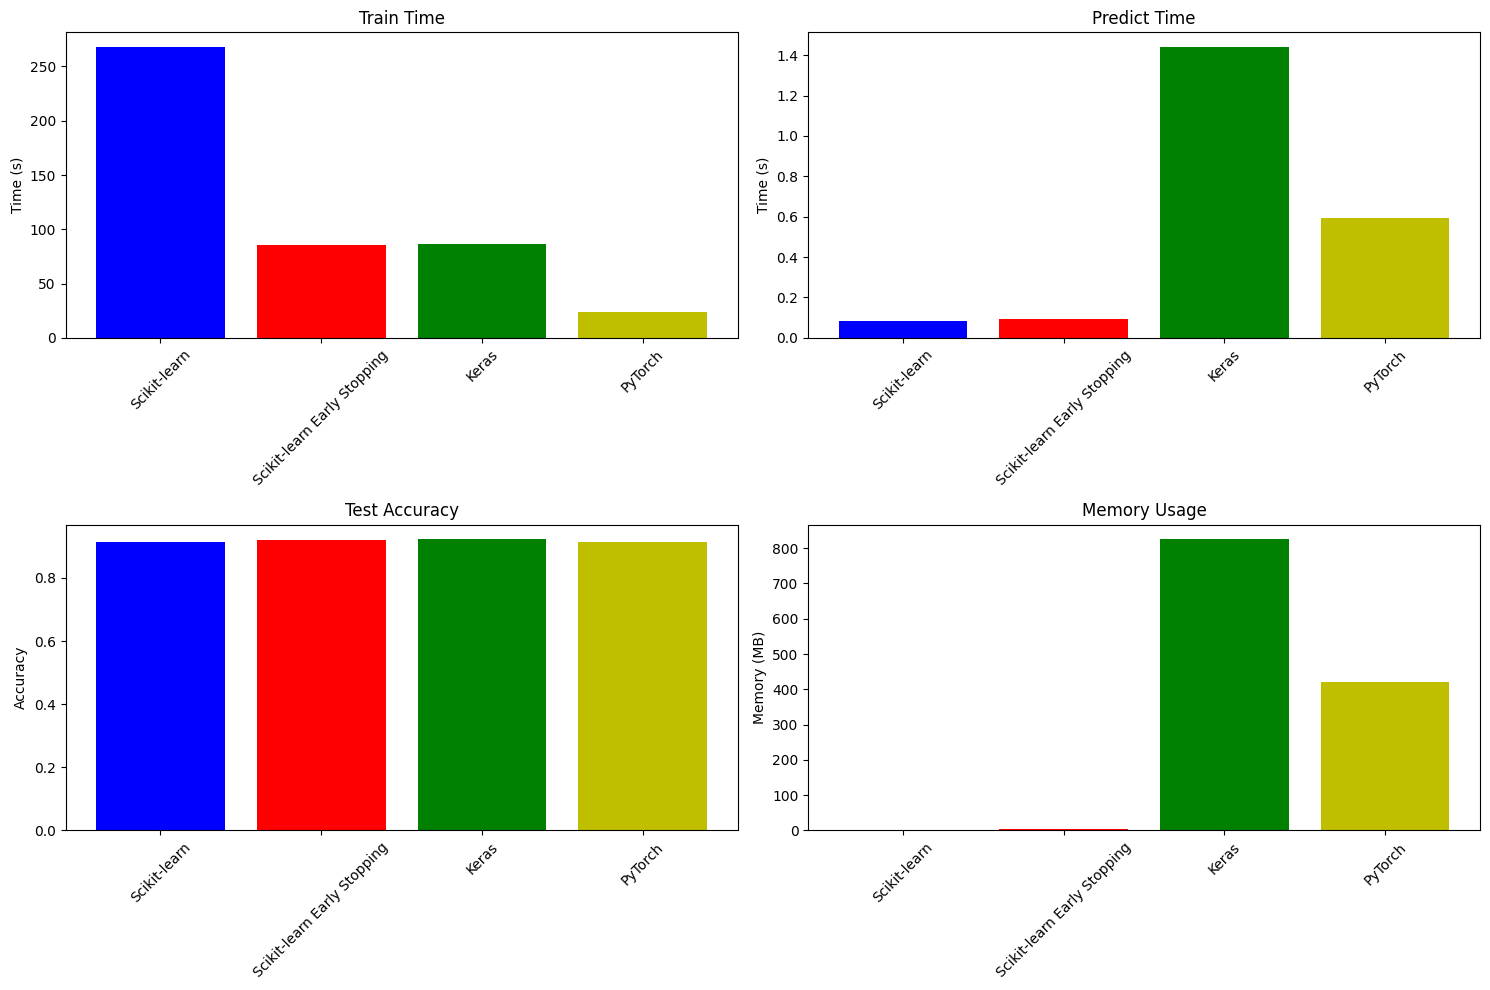

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Creating the DataFrame
data = {
    "Implementation": ["Scikit-learn", "Scikit-learn Early Stopping", "Keras", "PyTorch"],
    "Train Time": [268.03, 85.55, 86.53, 24.21],
    "Predict Time": [0.082, 0.091, 1.441, 0.596],
    "Test Accuracy": [0.914, 0.920, 0.922, 0.914],
    "Memory Usage": [0.02, 3.88, 825.00, 419.85]
}

df = pd.DataFrame(data)

color_map = {
    "Scikit-learn": 'b',
    "Scikit-learn Early Stopping": 'r',
    "Keras": 'g',
    "PyTorch": 'y'
}

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].bar(df["Implementation"], df["Train Time"], color=[color_map[i] for i in df["Implementation"]])
ax[0, 0].set_title('Train Time')
ax[0, 0].set_ylabel('Time (s)')
ax[0, 0].tick_params(axis='x', rotation=45)

ax[0, 1].bar(df["Implementation"], df["Predict Time"], color=[color_map[i] for i in df["Implementation"]])
ax[0, 1].set_title('Predict Time')
ax[0, 1].set_ylabel('Time (s)')
ax[0, 1].tick_params(axis='x', rotation=45)

ax[1, 0].bar(df["Implementation"], df["Test Accuracy"], color=[color_map[i] for i in df["Implementation"]])
ax[1, 0].set_title('Test Accuracy')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].tick_params(axis='x', rotation=45)

ax[1, 1].bar(df["Implementation"], df["Memory Usage"], color=[color_map[i] for i in df["Implementation"]])
ax[1, 1].set_title('Memory Usage')
ax[1, 1].set_ylabel('Memory (MB)')
ax[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()